# EDA
#### Charlie Liou

Let's first use the word "Robotic" to refer to songs where an external songwriter was credited.
In this notebook, we do several exploratory analyses:

- Log-odds ratio of words in robotic songs and words in non-robotic songs
- Sentiment analysis between robotic and non-robotic songs
- Latent Dirichlet Allocation, unsupervised
- Word2Vec (when I figure out how to use Rtools with 3.5.1)
 - meanwhile, got a Python analysis going

In [1]:
# install.packages("magrittr")
# install.packages("tidytext")
# install.packages("ggplot2")
# install.packages("tm")
# install.packages("topicmodels")
# install.packages("broom")
# install.packages("devtools")
# devtools::install_github("bmschmidt/wordVectors") 
# Rtools not compatible w/ 3.5.1, MAJOR RIP

library(purrr)
library(magrittr)
library(tidyr)
library(tidytext)
library(dplyr)
library(stringr)
library(ggplot2)
library(tm)
library(topicmodels)
library(broom)


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names


Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



In [2]:
library = "C:\\Users\\liblabs-user\\Desktop\\song-authorship\\data"
laptop = "not yet"
desktop = "C:\\Users\\Sam\\Desktop\\song authorship\\data"

In [3]:
df <- read.csv(
    paste(desktop, "\\Weekly_data_clean.csv", sep = ""),
    encoding = "UTF-8",
    stringsAsFactors = FALSE)

In [37]:
reg <- "([^A-Za-z\\d#@']+|'[^A-Za-z\\d#@]+)"

df_words <- df %>%
    unnest_tokens(word, Lyrics, token = "regex", pattern = reg, collapse = TRUE) %>%
    filter(!word %in% stop_words$word, 
           str_detect(word, "[a-z]"))

df_bigrams <- map_df(2, 
           ~ unnest_tokens(df, word, text, 
                           token = "ngrams", n = .x)) %>%
    filter(!word %in% stop_words$word, 
           str_detect(word, "[a-z]"))

ERROR: Error in summarise_impl(.data, dots): Evaluation error: argument `...` should be a character vector (or an object coercible to).


## Analysis on all data

In [5]:
num_words_to_filter = 5

### Log-odds ratio

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


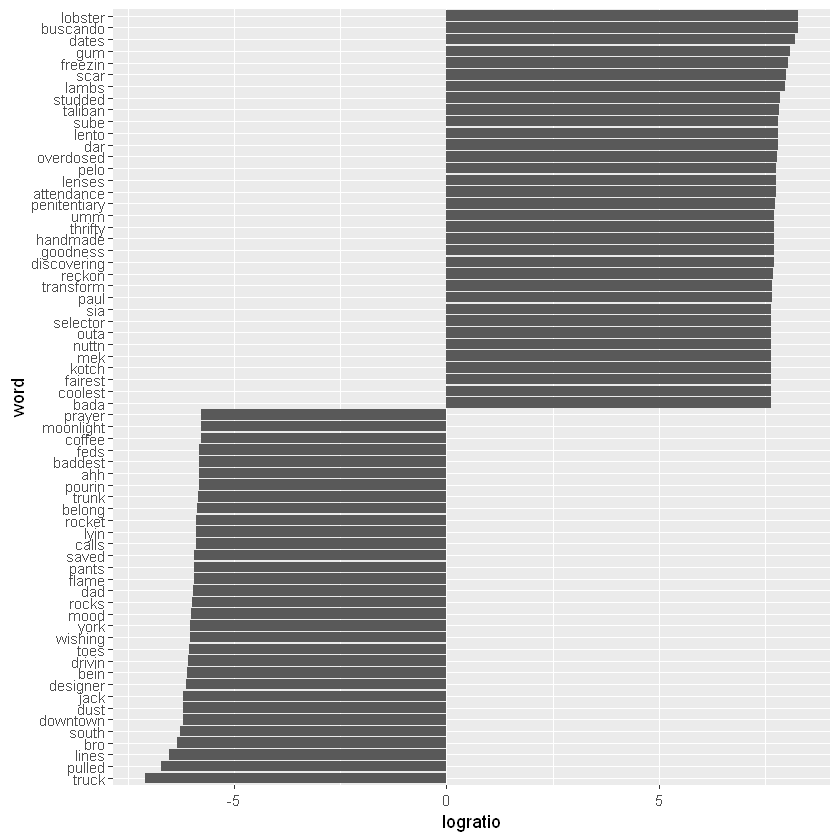

In [6]:
unique_df_words <- unique(df_words)

ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

rbind(ratios %>% top_n(30, logratio), ratios %>% top_n(-30, logratio)) %>%
    mutate(word = reorder(word, logratio)) %>%
    ggplot(aes(word, logratio)) +
    geom_col(show.legend = FALSE) +
    coord_flip()

### Sentiment Analysis

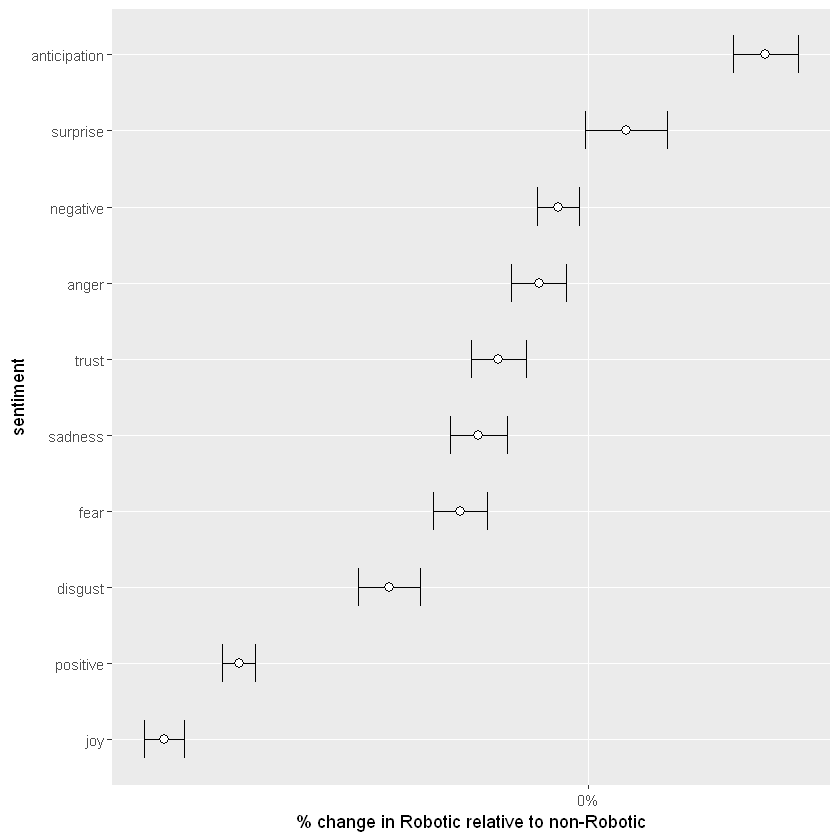

In [7]:
nrc <- sentiments %>%
    filter(lexicon == "nrc") %>%
    dplyr::select(word, sentiment)

sources <- df_words %>%
    group_by(Songwriter) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Songwriter, total_words)

by_source_sentiment <- df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Songwriter, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup()

# plot
sentiment_diff %>%
    mutate(sentiment = reorder(sentiment, estimate)) %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("% change in Robotic relative to non-Robotic",
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip()

Which words contributed the most to each sentiment category?
We use the previous ratios data frame to find out.

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


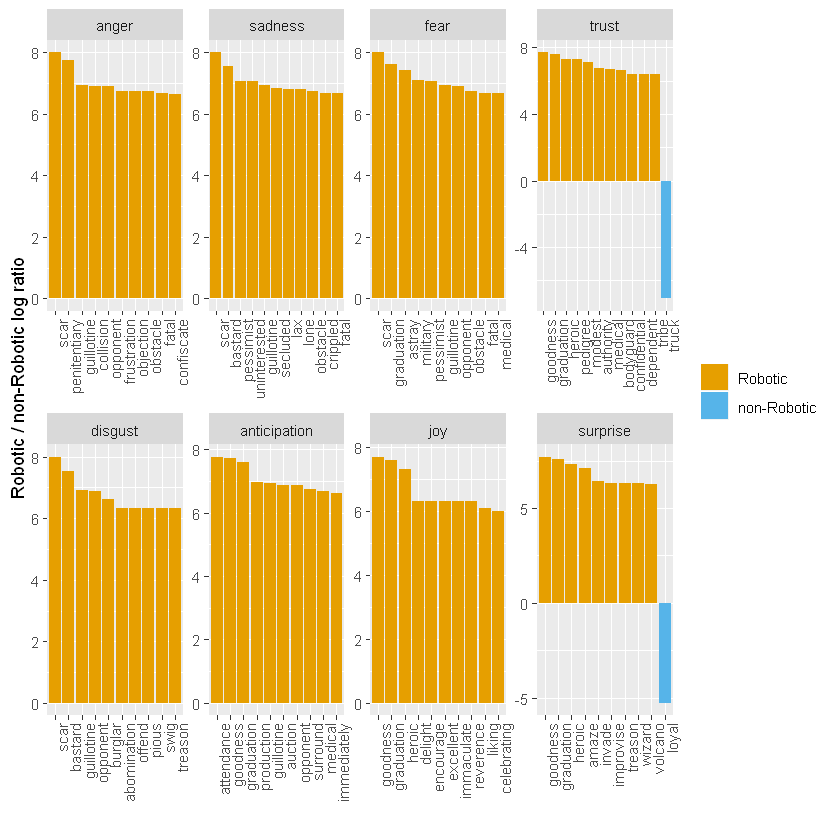

In [8]:
ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

ratios %>%
    inner_join(nrc, by = "word") %>%
    filter(!sentiment %in% c("positive", "negative")) %>%
    mutate(sentiment = reorder(sentiment, -logratio),
           word = reorder(word, -logratio)) %>%
    group_by(sentiment) %>%
    top_n(10, abs(logratio)) %>%
    ungroup() %>%
    ggplot(aes(word, logratio, fill = logratio < 0)) +
    facet_wrap(~ sentiment, scales = "free", nrow = 2) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "Robotic / non-Robotic log ratio") +
    scale_fill_manual(name = "", labels = c("Robotic", "non-Robotic"),
                    values = c("#E69F00", "#56B4E9"))

### Latent Dirichlet Allocation

In [9]:
word_counts <- df_words %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > num_words_to_filter) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

Warning message:
"Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged."

We start with two topics. For both topics, let us first observe the most probable terms that will be generated from each topic (terms with high $\beta$).

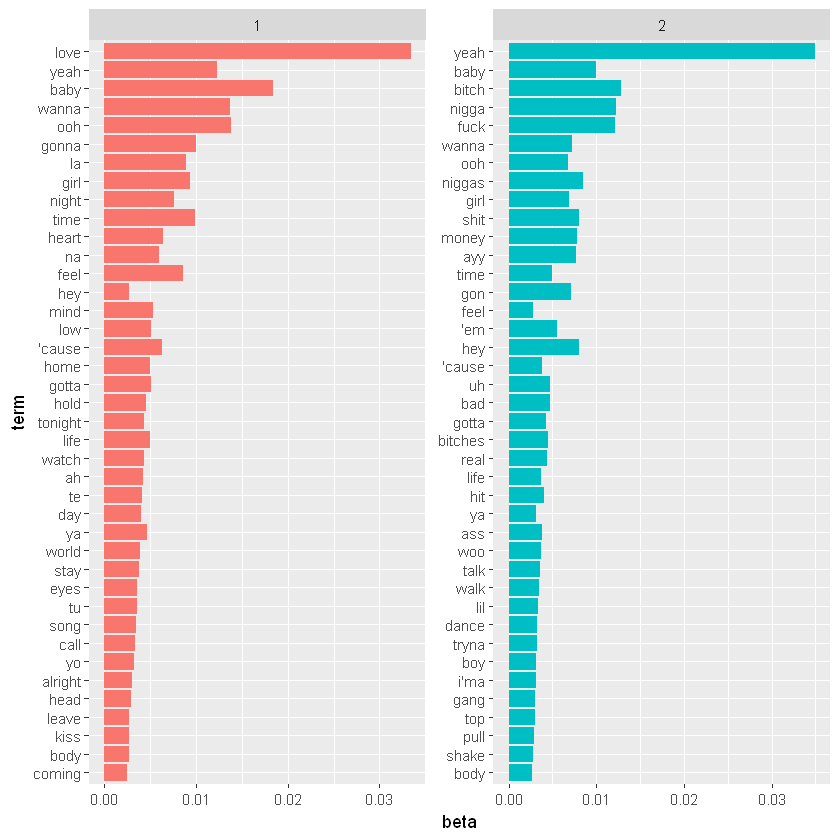

In [10]:
# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

We now consider words that had the greatest difference in $\beta$.

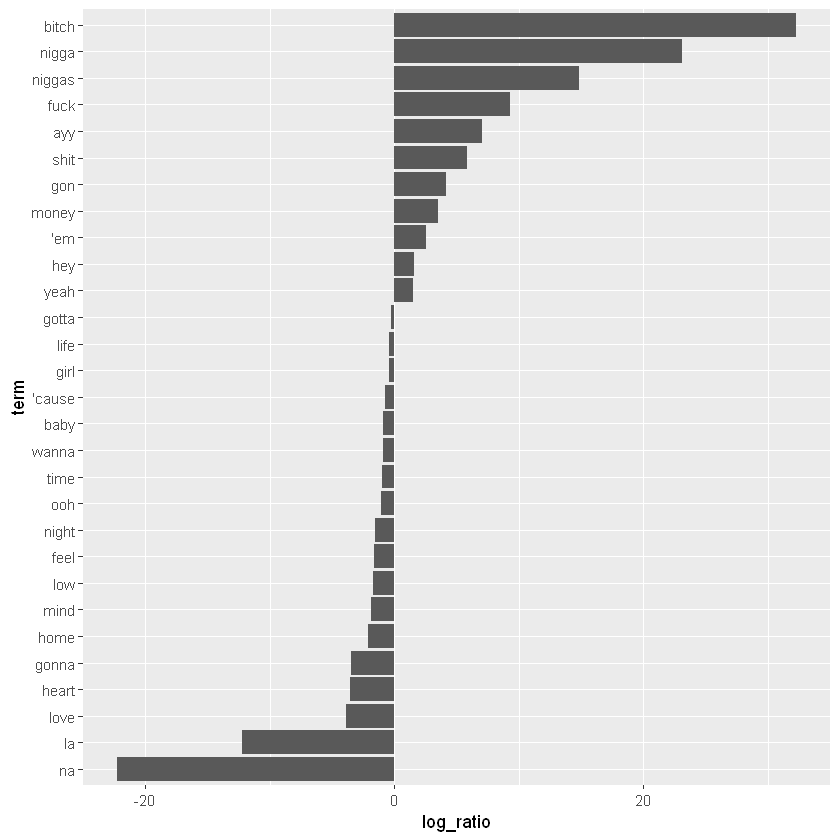

In [11]:
beta_spread <- topics %>%
    mutate(topic = paste0("topic", topic)) %>% # adds topic to each number
    spread(topic, beta) %>% # key, values w/ values for each var
    filter(topic1 > .005 | topic2 > .005) %>%
    mutate(log_ratio = log2(topic2 / topic1)) %>%
    #filter(abs(log_ratio) < 50) %>%
    arrange(-log_ratio)

# plot
beta_spread %>%
    mutate(term = reorder(term, log_ratio)) %>%
    ggplot(aes(term, log_ratio)) + 
    geom_col(show.legend = FALSE) +
    coord_flip()

In this case, topic 2 is definitely more of a hip-hop / rap topic.

## ${\Large \color{red}{\text{By  genre: Pop}}}$

We subset our data to just songs where the `Genre` variable contains "pop".

In [12]:
popdf <- df_words %>% 
    filter(str_detect(Genre, regex("pop", ignore_case = TRUE)))

### Log-odds ratio

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


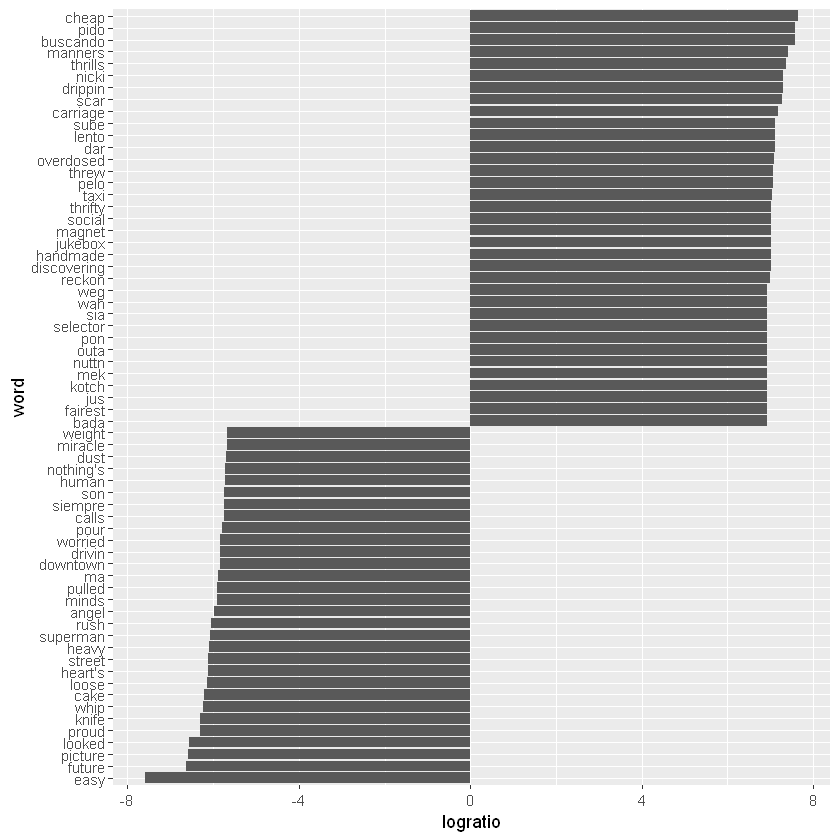

In [13]:
unique_df_words <- unique(popdf)

ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

rbind(ratios %>% top_n(30, logratio), ratios %>% top_n(-30, logratio)) %>%
    mutate(word = reorder(word, logratio)) %>%
    ggplot(aes(word, logratio)) +
    geom_col(show.legend = FALSE) +
    coord_flip()

### Sentiment Analysis

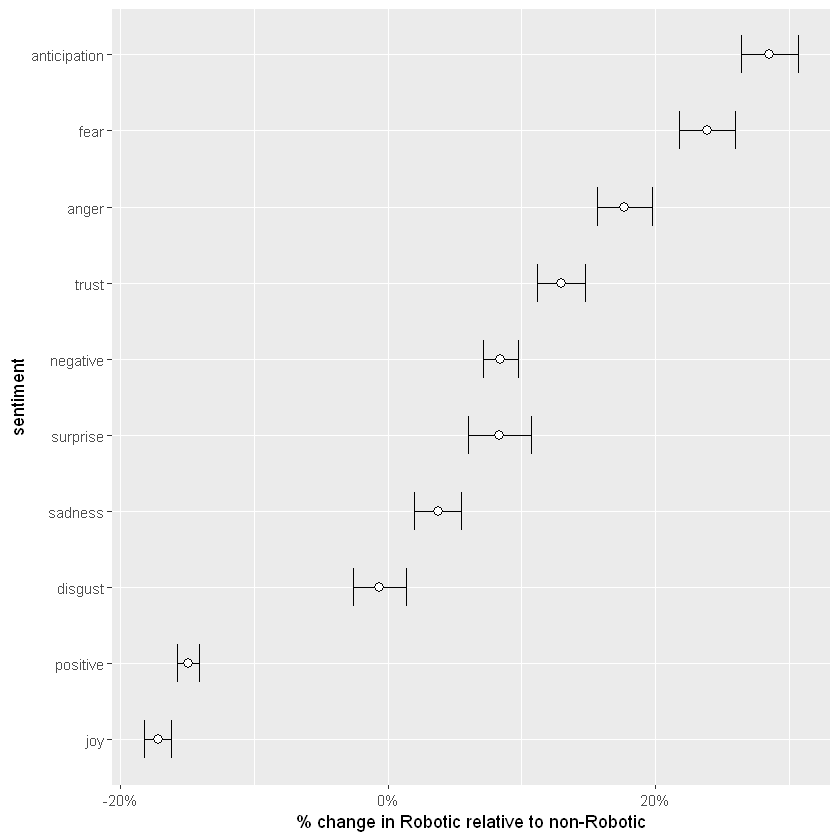

In [14]:
sources <- popdf %>%
    group_by(Songwriter) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Songwriter, total_words)

by_source_sentiment <- df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Songwriter, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup()

sentiment_diff %>%
    mutate(sentiment = reorder(sentiment, estimate)) %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("% change in Robotic relative to non-Robotic",
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip()

- Robotic songs use >20% more sentiments relating to anticipation and fear.

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


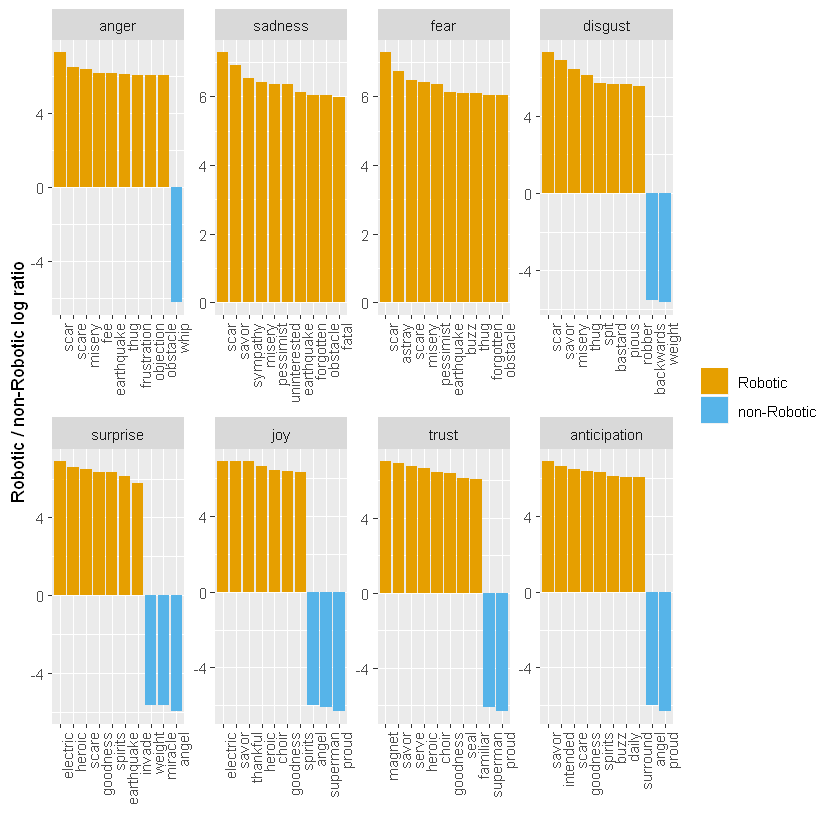

In [15]:
ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

ratios %>%
    inner_join(nrc, by = "word") %>%
    filter(!sentiment %in% c("positive", "negative")) %>%
    mutate(sentiment = reorder(sentiment, -logratio),
           word = reorder(word, -logratio)) %>%
    group_by(sentiment) %>%
    top_n(10, abs(logratio)) %>%
    ungroup() %>%
    ggplot(aes(word, logratio, fill = logratio < 0)) +
    facet_wrap(~ sentiment, scales = "free", nrow = 2) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "Robotic / non-Robotic log ratio") +
    scale_fill_manual(name = "", labels = c("Robotic", "non-Robotic"),
                    values = c("#E69F00", "#56B4E9"))

### Latent Dirichlet Allocation

In [25]:
word_counts <- popdf %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > num_words_to_filter) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

Warning message:
"Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged."

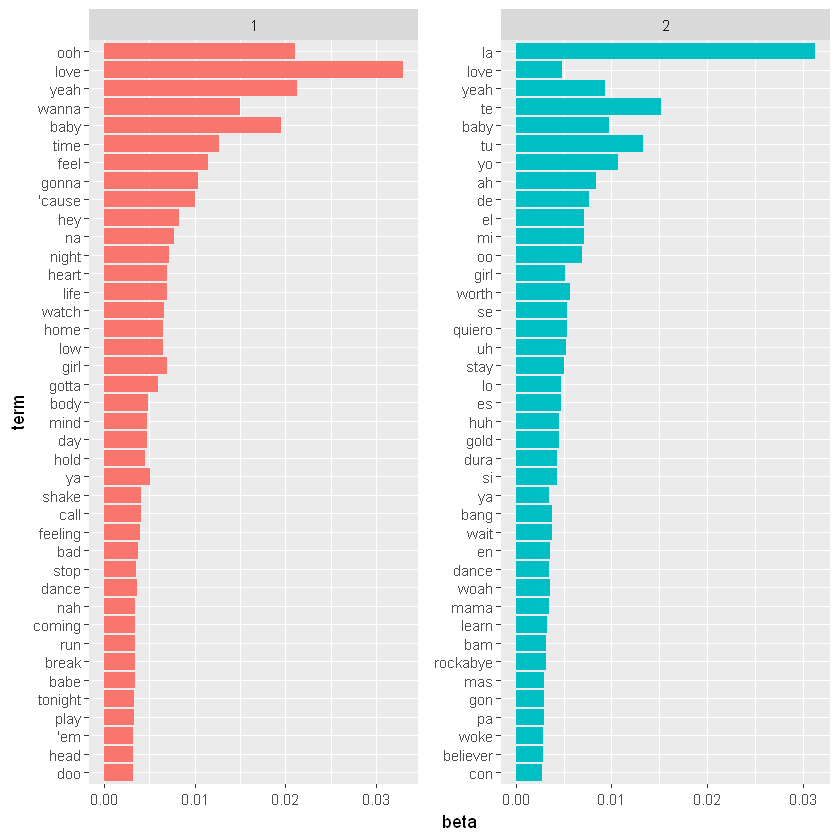

In [17]:
# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

## ${\Large \color{red}{\text{By  genre: Rap}}}$

In [18]:
rapdf <- df_words %>% 
         filter(str_detect(Genre, regex("Rap", ignore_case = TRUE)))

### Log-odds

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


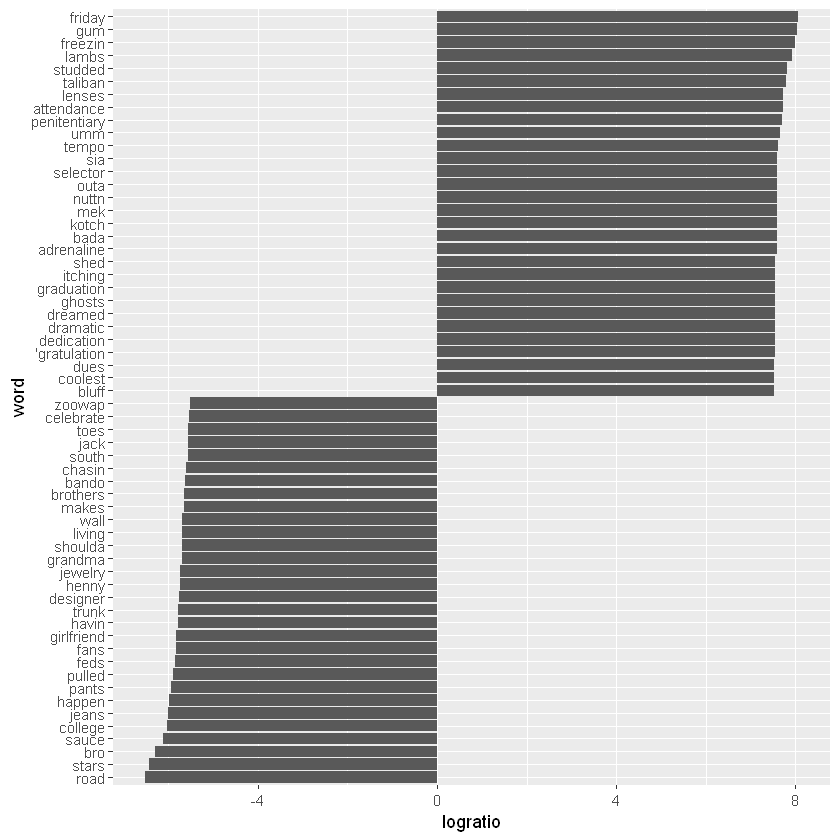

In [19]:
unique_df_words <- unique(rapdf)

ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

rbind(ratios %>% top_n(30, logratio), ratios %>% top_n(-30, logratio)) %>%
    mutate(word = reorder(word, logratio)) %>%
    ggplot(aes(word, logratio)) +
    geom_col(show.legend = FALSE) +
    coord_flip()

### Sentiment Analysis

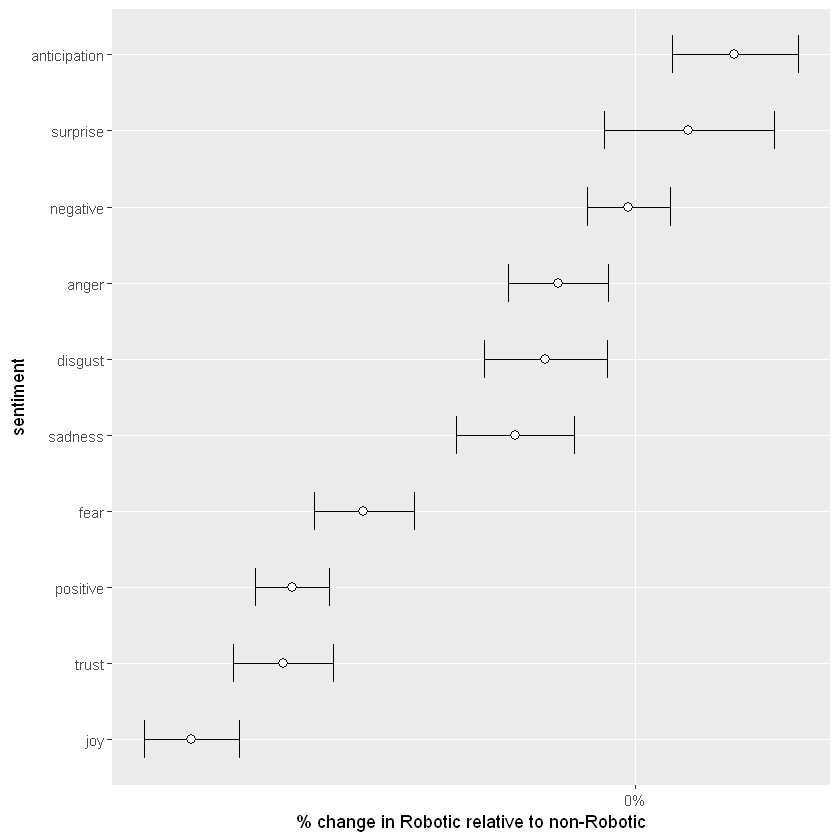

In [20]:
sources <- rapdf %>%
    group_by(Songwriter) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Songwriter, total_words)

by_source_sentiment <- df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Songwriter, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup()

sentiment_diff %>%
    mutate(sentiment = reorder(sentiment, estimate)) %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("% change in Robotic relative to non-Robotic",
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip()

#### *you should merge the sentiment visualization across all genres*

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


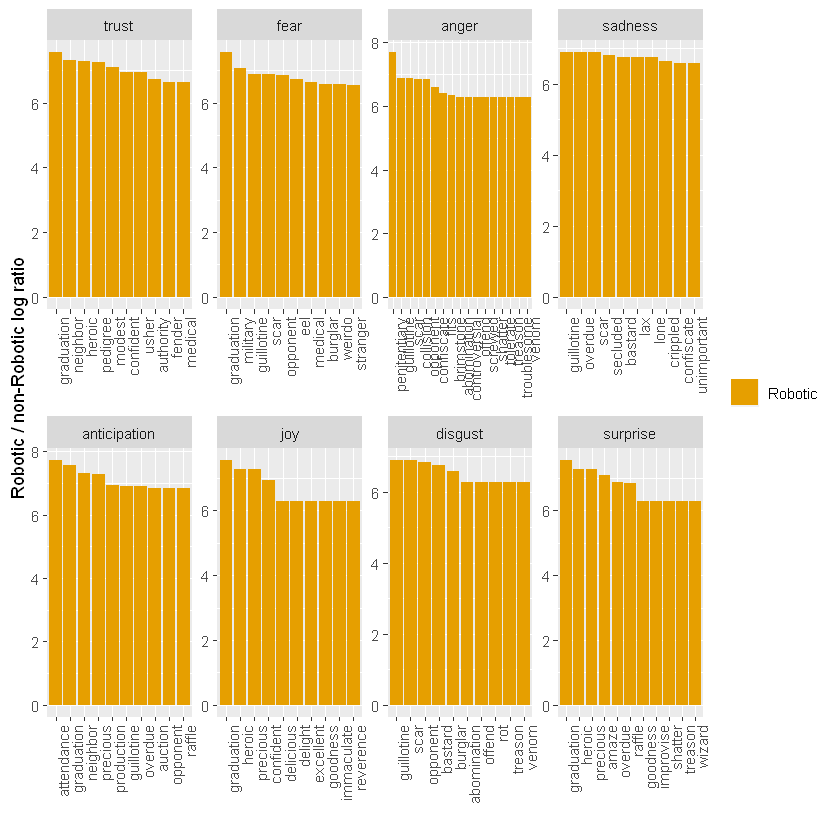

In [21]:
ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > num_words_to_filter) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

ratios %>%
    inner_join(nrc, by = "word") %>%
    filter(!sentiment %in% c("positive", "negative")) %>%
    mutate(sentiment = reorder(sentiment, -logratio),
           word = reorder(word, -logratio)) %>%
    group_by(sentiment) %>%
    top_n(10, abs(logratio)) %>%
    ungroup() %>%
    ggplot(aes(word, logratio, fill = logratio < 0)) +
    facet_wrap(~ sentiment, scales = "free", nrow = 2) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "Robotic / non-Robotic log ratio") +
    scale_fill_manual(name = "", labels = c("Robotic", "non-Robotic"),
                    values = c("#E69F00", "#56B4E9"))

### LDA

In [22]:
word_counts <- rapdf %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > num_words_to_filter) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

Warning message:
"Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged."

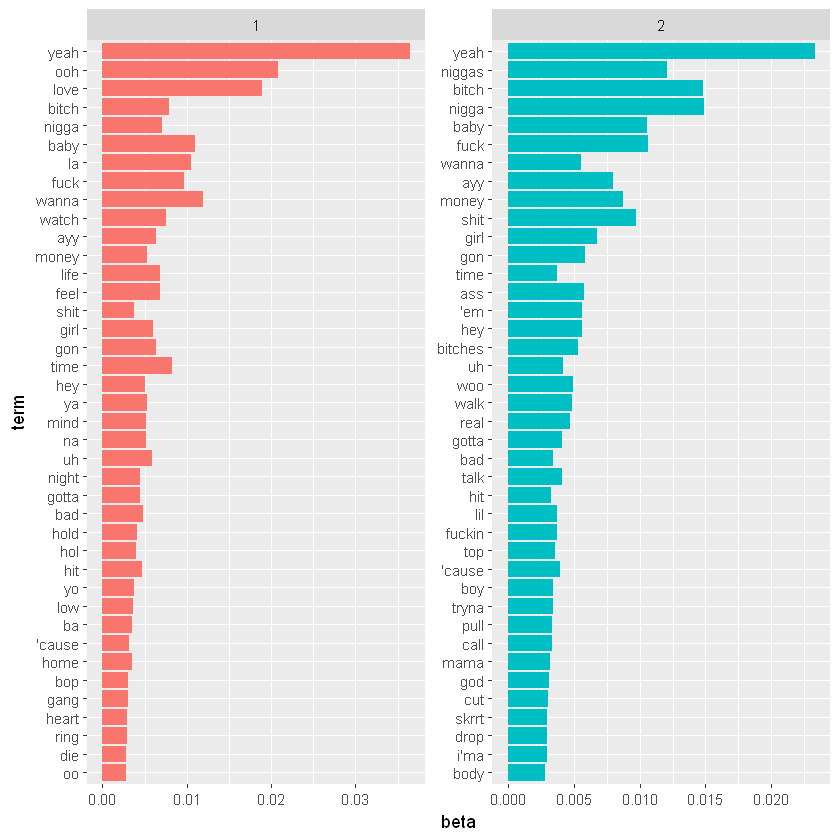

In [23]:
# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

Big conclusions:
- Across all genres (and in general), positive and joy sentiments appeared, on average, less in non-Robotic songs vs. Robotic songs.